# Simple guide RNA visualization and assignment with pertpy

This notebook demonstrates how to visualize guide RNAs in a perturbational assay and how to use pertpy functions to assign relevant guides to each cell.

The simple assignment method is obtained from the [mixscape pipeline](https://satijalab.org/seurat/articles/mixscape_vignette.html).

Reference: Papalexi, E., Mimitou, E.P., Butler, A.W. et al. Characterizing the molecular regulation of inhibitory immune checkpoints with multimodal single-cell screens. Nat Genet 53, 322–331 (2021). https://doi.org/10.1038/s41588-021-00778-2

In [2]:
import pertpy as pt
import scanpy as sc
import scipy

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

Guides should be available as a separate AnnData object containing counts of each guide for each cell. Var names of the AnnData correspond to the ID of these guides. In this example the gdo modality contains guide RNA expression values.

In [3]:
mdata = pt.data.papalexi_2021()
# seems like an error in the original data
mdata.mod['gdo'].X = scipy.sparse.csr_matrix(mdata.mod['gdo'].X.A - 1)
gdo = mdata.mod['gdo']
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

Then we save the original count values and transform the data using the log transformation.

In [4]:
gdo.layers['counts'] = gdo.X.copy()
sc.pp.log1p(gdo)
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    uns: 'log1p'
    layers: 'counts'

We can visualize the expression of guides per cells to get more insight. By passing the argument `key_to_save_order` to the function, the order of cells in the plot will be saved in obs of the data.

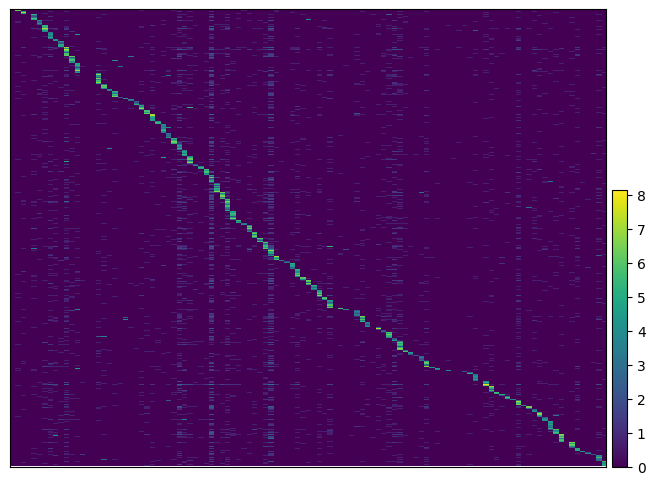

In [5]:
pt.pl.guide.heatmap(gdo, key_to_save_order='plot_order')

In [6]:
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'plot_order'
    var: 'name'
    uns: 'log1p'
    layers: 'counts'

Then we assign guides based on a simple thresholding mechanism. Here we consider a guide only if there is at least 5 counts. Please note which layer you pass to the function.

In [7]:
ga = pt.pp.GuideAssignment()
ga.assign_by_threshold(gdo, 5, layer='counts')
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'plot_order'
    var: 'name'
    uns: 'log1p'
    layers: 'counts', 'assigned_guides'

Then we again plot the heatmap of the assigned guides to see the effect of the assignment. 
We use the same ordering as in the previous plot to that we can compare the two plots.

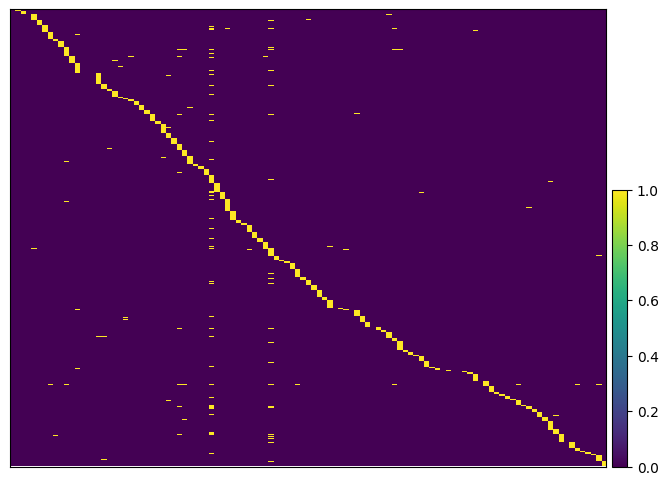

In [8]:
pt.pl.guide.heatmap(gdo, layer='assigned_guides', order_by='plot_order')

We can also assign to the guide with the highest detection using the following function.

In [9]:
ga = pt.pp.GuideAssignment()
ga.assign_to_max_guide(gdo, 5, layer='counts')

As we see it completely maches the guide assignment in the mixscape pipeline:

In [10]:
sum(gdo.obs['assigned_guide'] != gdo.obs['guide_ID'])

0